# Data, and noise, in linear or log space

This notebooks explores the difference using data (and the noise) model in linear and logspace.


In [1]:
try:
    # Check if the code is running in an IPython kernel (which includes Jupyter notebooks)
    get_ipython()
    # If the above line doesn't raise an error, it means we are in a Jupyter environment
    # Execute the magic commands using IPython's run_line_magic function
    get_ipython().run_line_magic('load_ext', 'autoreload')
    get_ipython().run_line_magic('autoreload', '2')
except:
    # If get_ipython() raises an error, we are not in a Jupyter environment
    # # # # # #%load_ext autoreload
    # # # # # #%autoreload 2
    pass

In [2]:
import integrate as ig
# check if parallel computations can be performed
parallel = ig.use_parallel(showInfo=1)
hardcopy = True 
import numpy as np
import matplotlib.pyplot as plt

Notebook detected. Parallel processing is OK


## 0. Get some TTEM data

Getting data for case: HADERUP
Checking if file exists on the remote server...
Downloaded HADERUP_MEAN_ALL.h5
Checking if file exists on the remote server...
Downloaded TX07_Haderup_mean.gex
Checking if file exists on the remote server...
Downloaded README_HADERUP
--> Got data for case: HADERUP
Using data file: HADERUP_MEAN_ALL.h5
Using GEX file: TX07_Haderup_mean.gex
f_data_h5=HADERUP_MEAN_ALL.h5


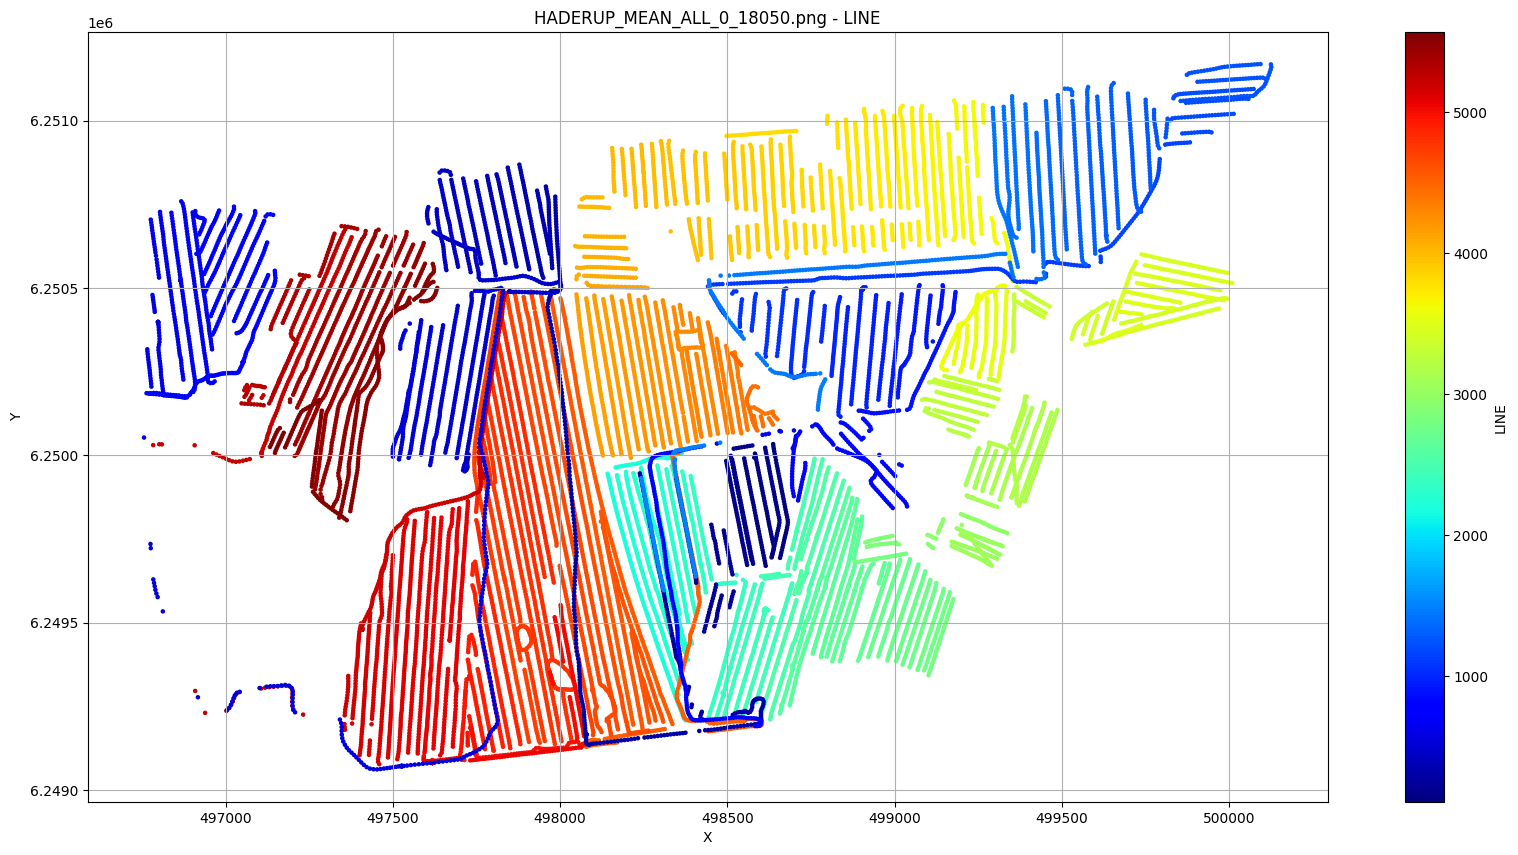

In [3]:
case = 'HADERUP'
files = ig.get_case_data(case=case, showInfo=2)
f_data_h5 = files[0]
file_gex= ig.get_gex_file_from_data(f_data_h5)

print("Using data file: %s" % f_data_h5)
print("Using GEX file: %s" % file_gex)


ig.plot_geometry(f_data_h5, pl='LINE')

plot_data: Found data set D1
plot_data: Using data set D1


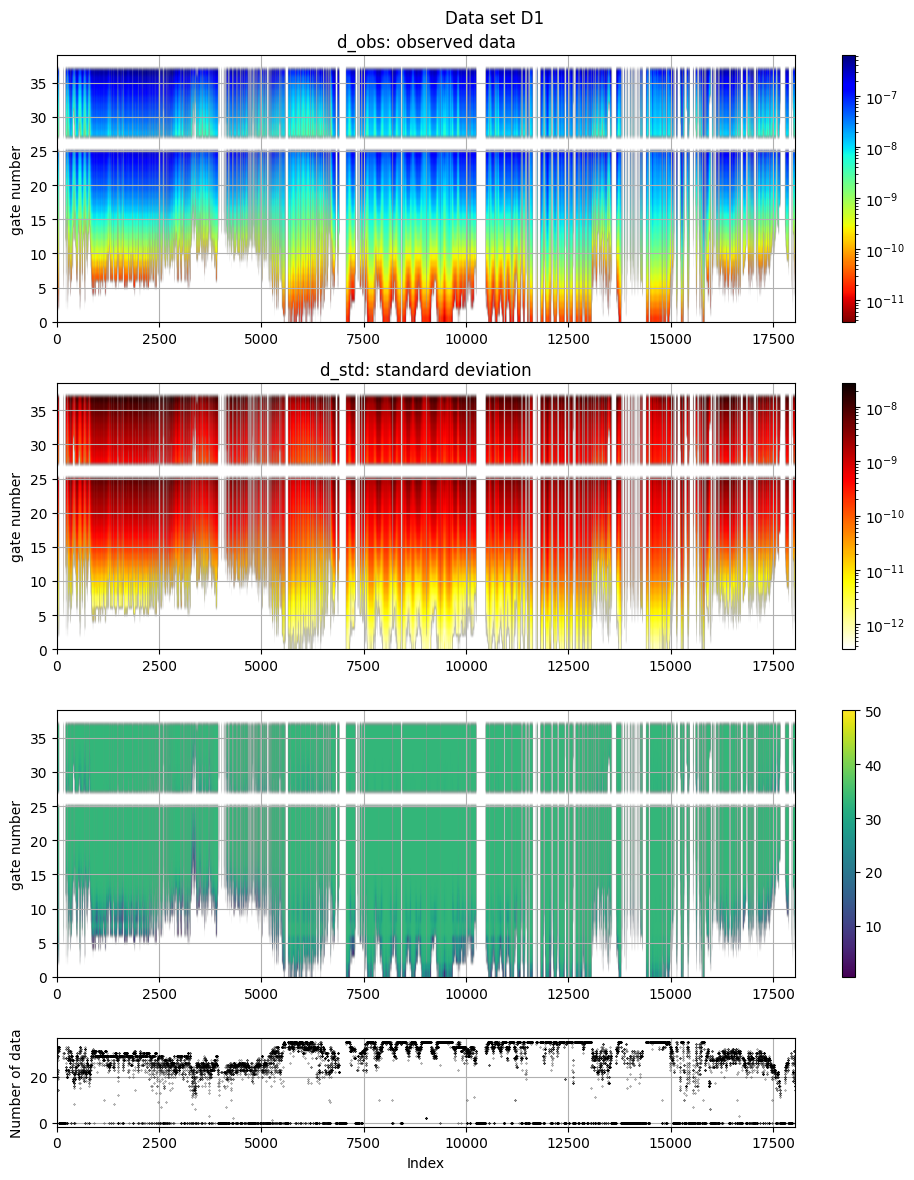

In [4]:
# The data, d_obs and d_std, can be plotted using ig.plot_data
ig.plot_data(f_data_h5, hardcopy=hardcopy)

In [5]:
# ## Create a dataset in log-space
f_data_log_h5 = 'DATA_LOGSPACE.h5'
ig.copy_hdf5_file(f_data_h5, f_data_log_h5)
DATA = ig.load_data(f_data_h5)
D_obs = DATA['d_obs'][0]
D_std = DATA['d_std'][0]

lD_obs = np.log10(D_obs)

lD_std_up = np.abs(np.log10(D_obs+D_std)-lD_obs)
lD_std_down = np.abs(np.log10(D_obs-D_std)-lD_obs)
corr_std = 0.02
lD_std = np.abs((lD_std_up+lD_std_down)/2) + corr_std

ig.write_data_gaussian(lD_obs, D_std = lD_std, f_data_h5 = f_data_log_h5, id=1, showInfo=0, is_log=1)

lDATA = ig.load_data(f_data_log_h5)

Loading data from HADERUP_MEAN_ALL.h5. Using data types: [1]
  - D1: id_use=1,    gaussian, Using 18050/39 data
Removing group DATA_LOGSPACE.h5:D1 
Adding group DATA_LOGSPACE.h5:D1 
Loading data from DATA_LOGSPACE.h5. Using data types: [1]
  - D1: id_use=1,    gaussian, Using 18050/39 data


/tmp/ipykernel_8126/201770367.py:11: RuntimeWarning: invalid value encountered in log10
  lD_std_down = np.abs(np.log10(D_obs-D_std)-lD_obs)


## 1. Setup the prior model ($\rho(\mathbf{m},\mathbf{d})$


In [6]:
# Select how many, N, prior realizations should be generated
N=200000
f_prior_h5 = ig.prior_model_layered(N=N,lay_dist='chi2', NLAY_deg=4, RHO_min=1, RHO_max=3000, f_prior_h5='PRIOR.h5')
print('%s is used to hold prior realizations' % (f_prior_h5))

File PRIOR.h5 does not exist.
PRIOR.h5 is used to hold prior realizations


### 1b. Then, a corresponding sample of $\rho(\mathbf{d})$, will be generated

Then the prior data, corresponding to the prior model parameters, are computed, using the GA-AEM code and the GEX file (from the DATA).



In [7]:
# Compute prior data in linear space
f_prior_data_h5 = ig.copy_hdf5_file(f_prior_h5,'PRIOR_DATA_linear.h5')
f_prior_data_h5 = ig.prior_data_gaaem(f_prior_data_h5, file_gex, doMakePriorCopy=False, parallel=parallel)
# Compute prior data in log space
f_prior_data_log_h5 = ig.copy_hdf5_file(f_prior_h5,'PRIOR_DATA_log.h5')
f_prior_data_log_h5 = ig.prior_data_gaaem(f_prior_data_log_h5, file_gex, doMakePriorCopy=False, is_log=True)

prior_data_gaaem: Using 32 parallel threads.


prior_data_gaaem: Time=198.9s/200000 soundings.  1.0ms/sounding, 1005.3it/s
prior_data_gaaem: Using 32 parallel threads.


prior_data_gaaem: Time=243.8s/200000 soundings.  1.2ms/sounding, 820.3it/s


/mnt/space/space_au11687/PROGRAMMING/integrate_module/integrate/integrate.py:1139: RuntimeWarning: invalid value encountered in log10
  D = np.log10(D)


id_data = 1


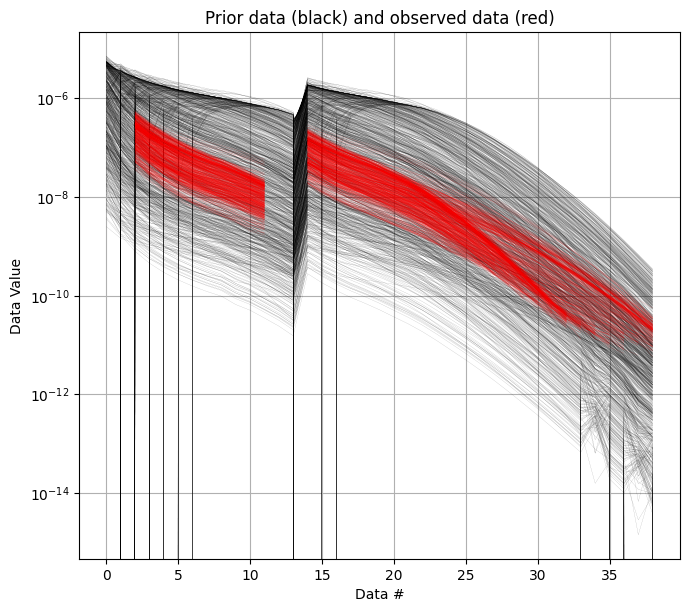

True

In [8]:
ig.plot_data_prior(f_prior_data_h5,f_data_h5,nr=1000,hardcopy=hardcopy)

In [9]:
#ig.plot_data_prior(f_prior_data_log_h5,f_data_log_h5,nr=1000,hardcopy=hardcopy)
#
# The posterior distribution is sampled using the extended rejection sampler.

In [10]:
# Rejection sampling in linear space
N_use = N
T_base = 1 # The base annealing temperature. 
autoT = 1  # Automatically set the annealing temperature
f_post_h5 = ig.integrate_rejection(f_prior_data_h5, 
                                   f_data_h5, 
                                   f_post_h5 = 'POST_linear.h5', 
                                   N_use = N_use,
                                   )

integrate_rejection: Time=622.4s/18050 soundings, 34.5ms/sounding, 29.0it/s. T_av=25.5, EV_av=-43.9


In [11]:
f_post_log_h5 = ig.integrate_rejection(f_prior_data_log_h5, 
                                   f_data_log_h5, 
                                   f_post_h5 = 'POST_log.h5', 
                                   N_use = N_use,
                                   )

integrate_rejection: Time=615.2s/18050 soundings, 34.1ms/sounding, 29.3it/s. T_av=4.8, EV_av=-15.2


## 3. Plot some statistics from $\sigma(\mathbf{m})$


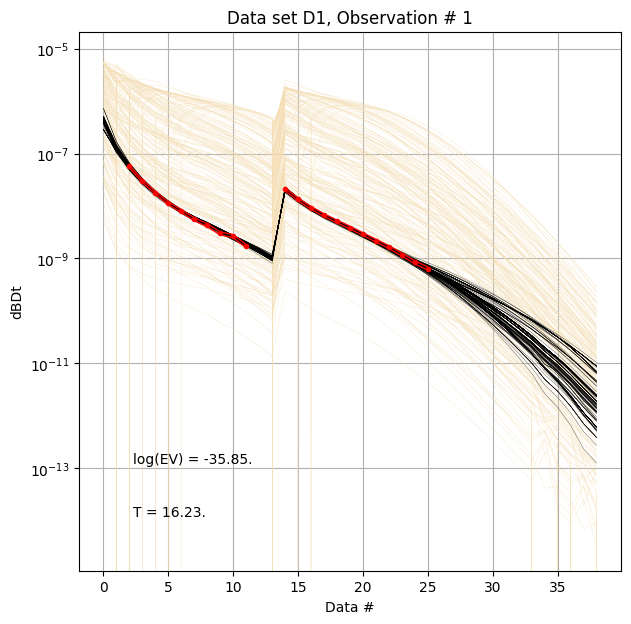

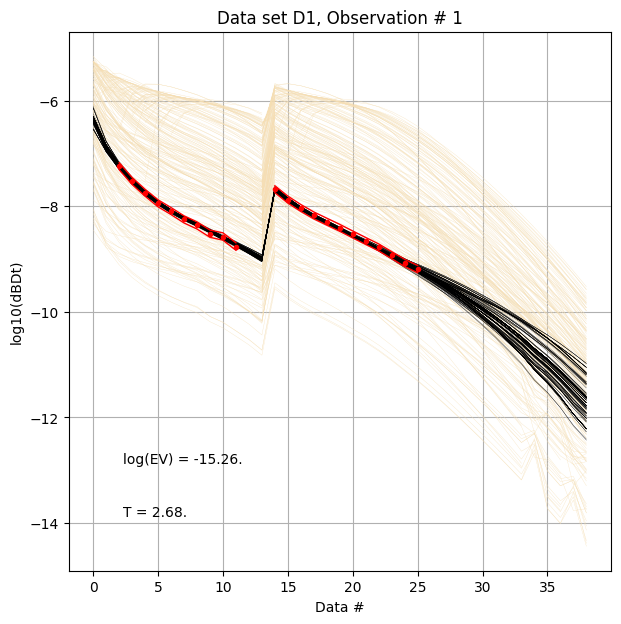

In [12]:
ig.plot_data_prior_post(f_post_h5, i_plot=0,hardcopy=hardcopy)
ig.plot_data_prior_post(f_post_log_h5, i_plot=0,hardcopy=hardcopy, is_log=True)

### Evidence and Temperature

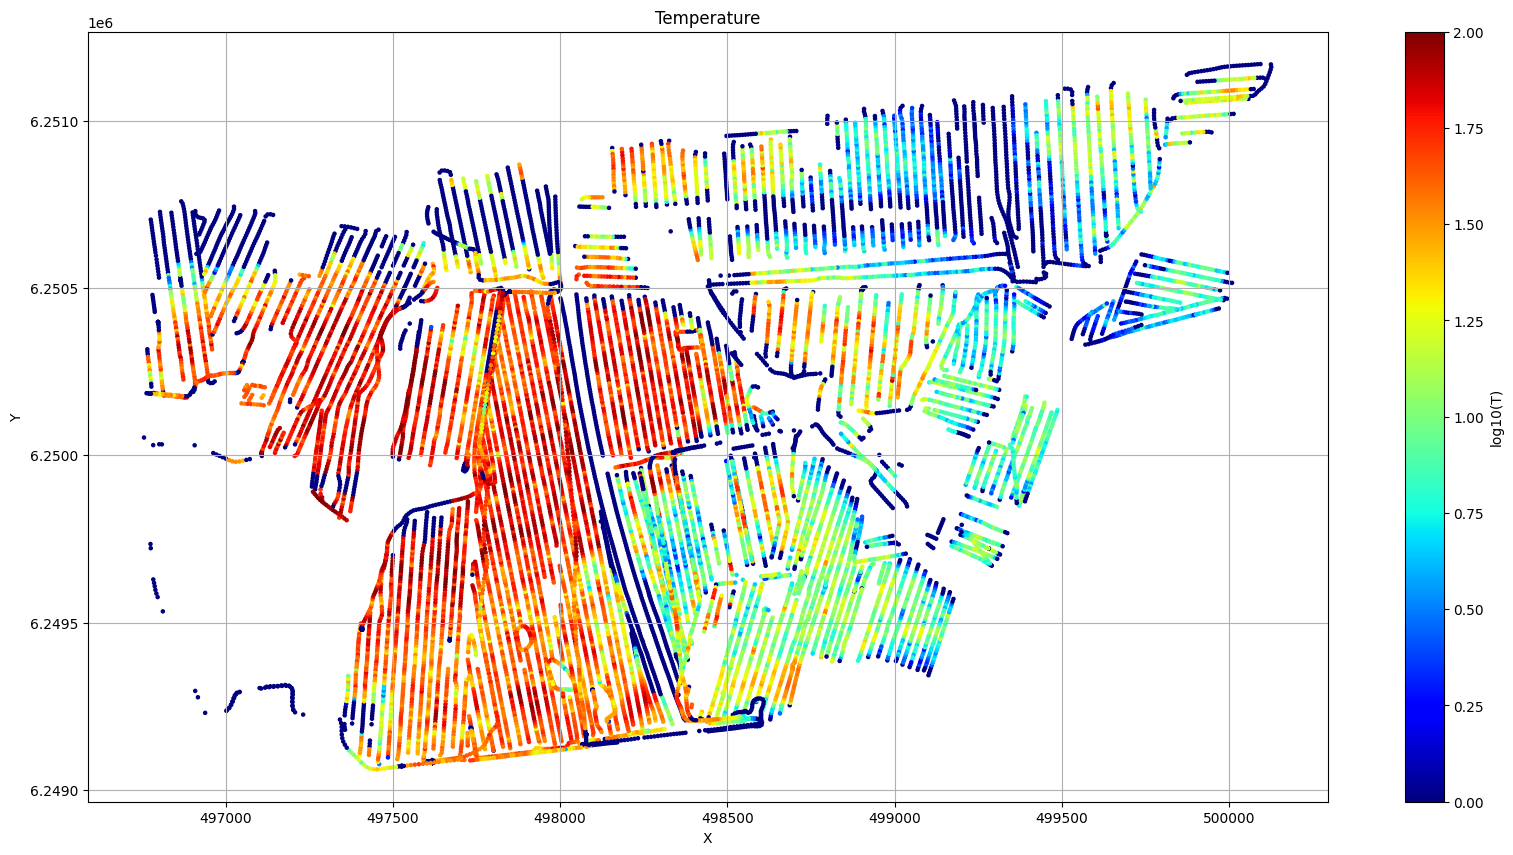

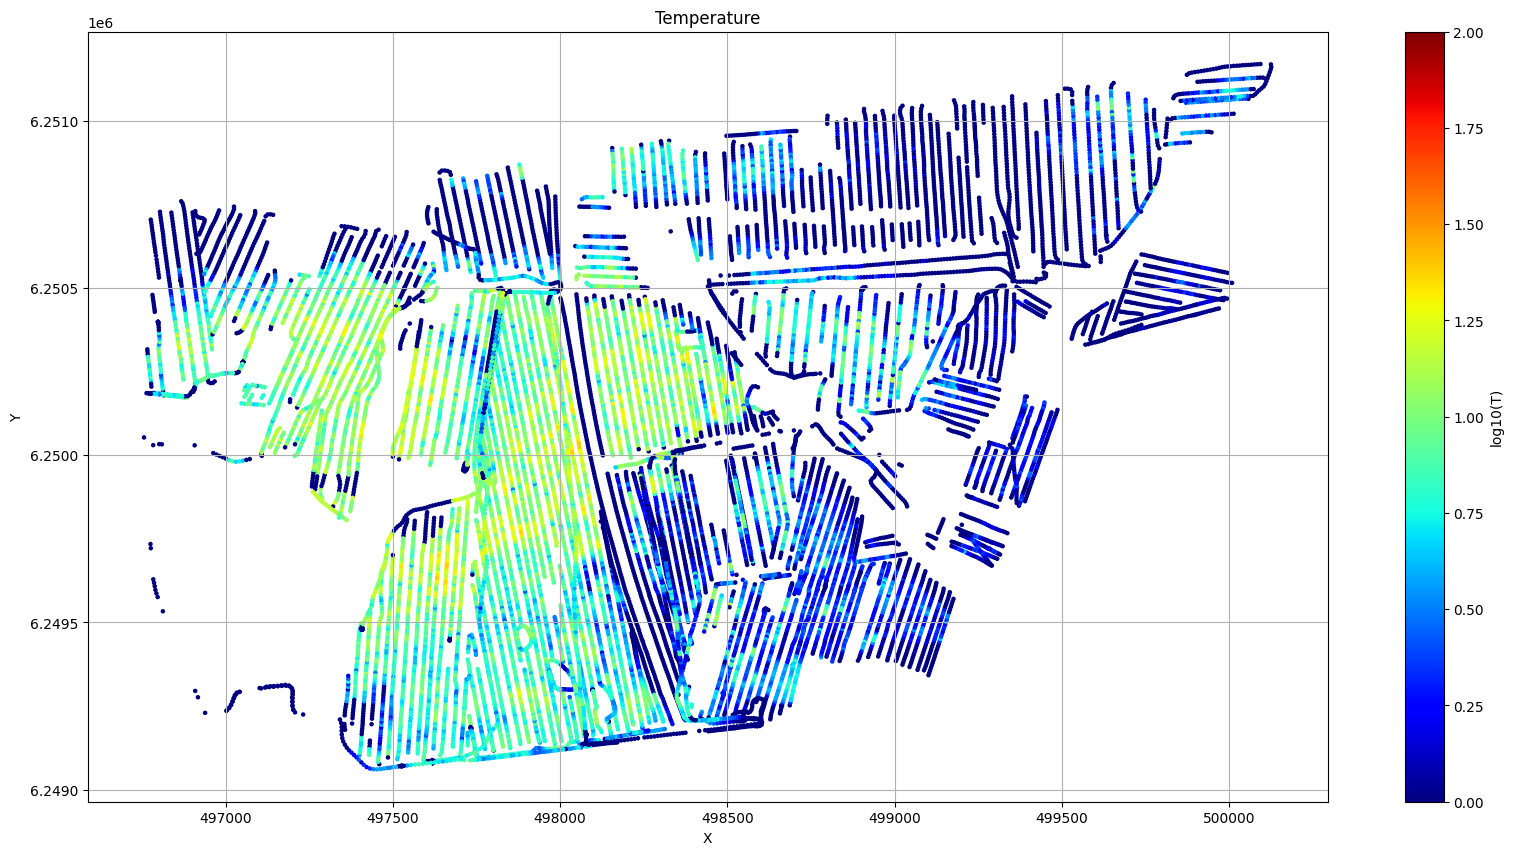

In [13]:
# Plot the Temperature used for inversion
ig.plot_T_EV(f_post_h5, pl='T',hardcopy=hardcopy)
ig.plot_T_EV(f_post_log_h5, pl='T',hardcopy=hardcopy)

### Profile

Plot a profile of posterior statistics of model parameters 1 (resistivity)

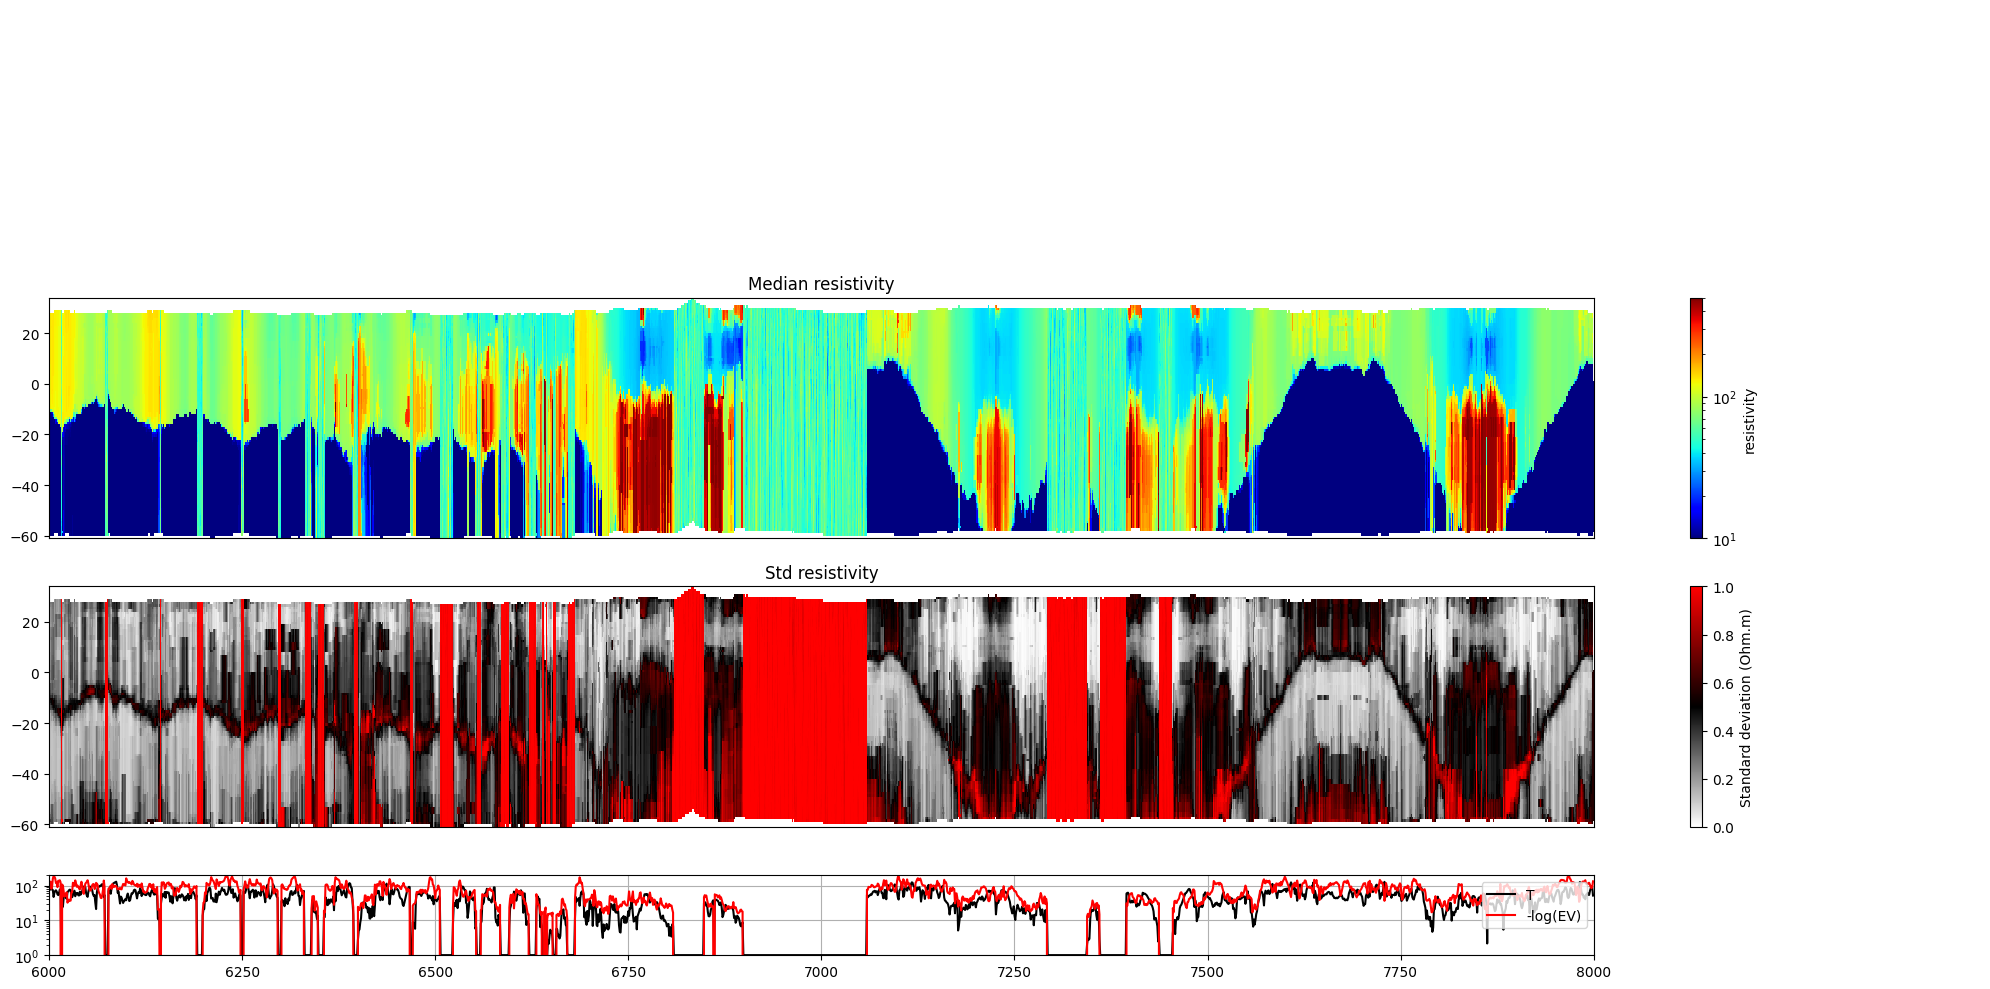

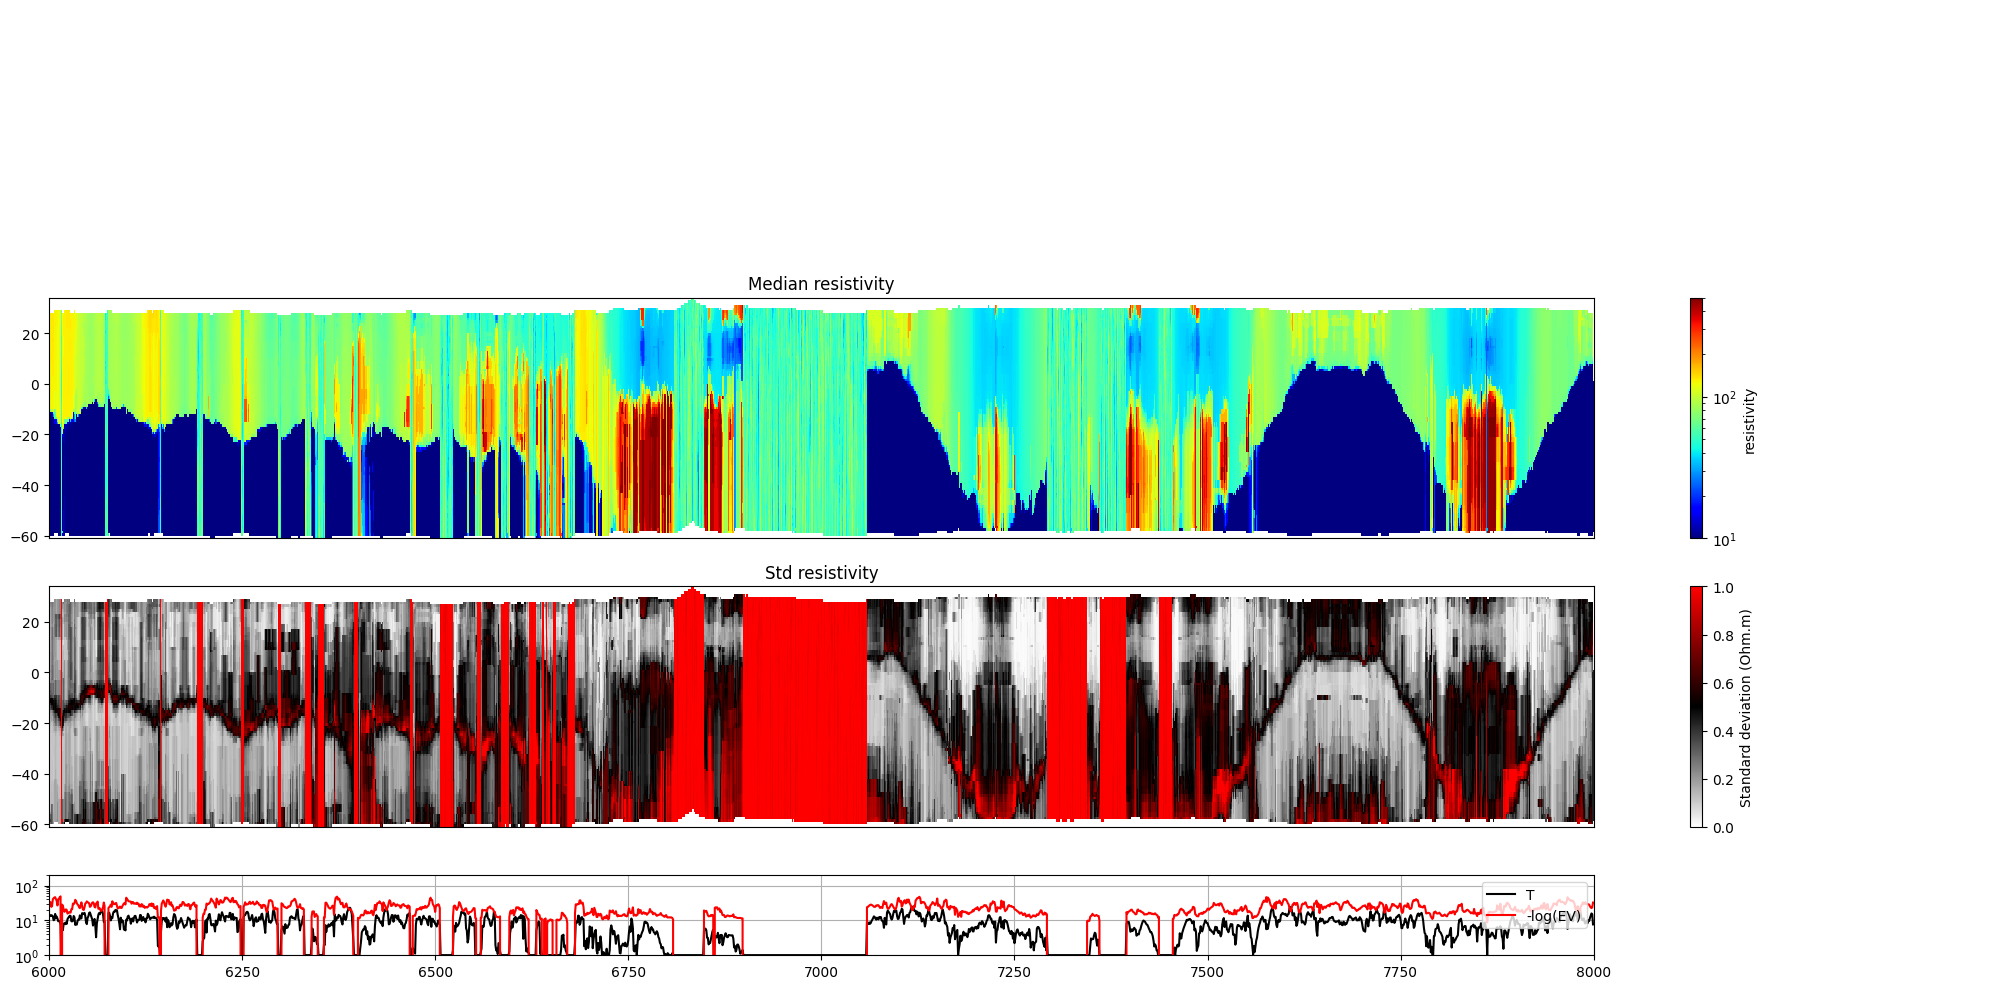

In [14]:
ig.plot_profile(f_post_h5, i1=6000, i2=8000, im=1, hardcopy=hardcopy)
ig.plot_profile(f_post_log_h5, i1=6000, i2=8000, im=1, hardcopy=hardcopy)